### Import data

In [12]:
include("importData.jl")
include("Hill.jl")
include("plot.jl")

# import G1, G2, and population data
conc, popl, g2l, g1l, g2_0l, g1_0l = setup_data("paclitaxel");
conc_l = append!([0.01], conc[2:end])

┌ Warning: `setindex!(df::DataFrame, v::AbstractVector, ::Colon, col_ind::ColumnIndex)` is deprecated, use `begin
│     df[!, col_ind] = v
│     df
│ end` instead.
│   caller = get_data(::String, ::String) at importData.jl:29
└ @ Main /home/farnazm/eh/DrugResponseModel.jl/src/importData.jl:29
┌ Warning: `setindex!(df::DataFrame, v::AbstractVector, ::Colon, col_ind::ColumnIndex)` is deprecated, use `begin
│     df[!, col_ind] = v
│     df
│ end` instead.
│   caller = get_data(::String, ::String) at importData.jl:37
└ @ Main /home/farnazm/eh/DrugResponseModel.jl/src/importData.jl:37


8-element Array{Float64,1}:
  0.01
  0.1 
  1.0 
  2.0 
  3.0 
  5.0 
  7.5 
 15.0 

### Hill model, residual functions and optimization

In [2]:
#  [EC50, b_steepness, alpha_min, alpha_max, beta_min, beta_max, tau1_mean, tau1_max, tau2_min, tau2_max, gamma1_max, gamma2_max]
# guess
guess = [15.0, 1.0, 0.00682578, 0.00958013, 0.00503788, 0.0933964, 38.941, 9.94827, 0.00294624, 0.0422821, 0.02, 0.008]
# max num of steps
num_steps=2000

best_fit, params = optimize_hill(guess, conc_l, g1l, g2l, g1_0l, g2_0l, num_steps)

Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64},RadiusLimitedSelector,BlackBoxOptim.AdaptiveDiffEvoRandBin{3},RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
100.05 secs, 695 evals, 595 steps, improv/step: 0.402 (last = 0.4017), fitness=33600.207234472
200.11 secs, 1396 evals, 1296 steps, improv/step: 0.353 (last = 0.3124), fitness=22232.571820214


┌ Warning: Optimization interrupted, recovering intermediate results...
└ @ BlackBoxOptim /home/farnazm/.julia/packages/BlackBoxOptim/ZdVko/src/opt_controller.jl:458


(22232.571820213612, [2.7614899186719435, 4.226433294707702, 0.010524133630852554, 0.05734095922233748, 0.04251876141906902, 0.029822291403032823, 19.01830492283447, 25.011887428274697, 8.967261854856122, 5.770477615907243, 0.03848427158853001, 0.0023969342346540808])

In [3]:
pars=getDDEparams(params, conc_l)

6×8 Array{Float64,2}:
  0.057341      0.0573409    0.0567099    …   0.0112005    0.0105608 
  0.0298223     0.0298223    0.0299934        0.0423353    0.0425088 
 25.0119       25.0119      24.9311          19.1049      19.023     
  5.77048       5.77048      5.81357          8.92108      8.96476   
  2.30261e-29   3.12166e-8   0.000518712      0.0379283    0.0384542 
  1.43414e-30   1.94428e-9   3.23072e-5   …   0.00236231   0.00239506

### Plot the data with the new set of parameters for DDE

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = plotIt(::Array{Float64,1}, ::Int64, ::String, ::Bool, ::DataFrame, ::Array{Float64,2}, ::Array{Float64,2}, ::Array{Float64,1}, ::Array{Float64,1}) at plot.jl:29
└ @ Main /home/farnazm/eh/DrugResponseModel.jl/src/plot.jl:29
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = plotIt(::Array{Float64,1}, ::Int64, ::String, ::Symbol, ::DataFrame, ::Array{Float64,2}, ::Array{Float64,2}, ::Array{Float64,1}, ::Array{Float64,1}) at plot.jl:29
└ @ Main /home/farnazm/eh/DrugResponseModel.jl/src/plot.jl:29


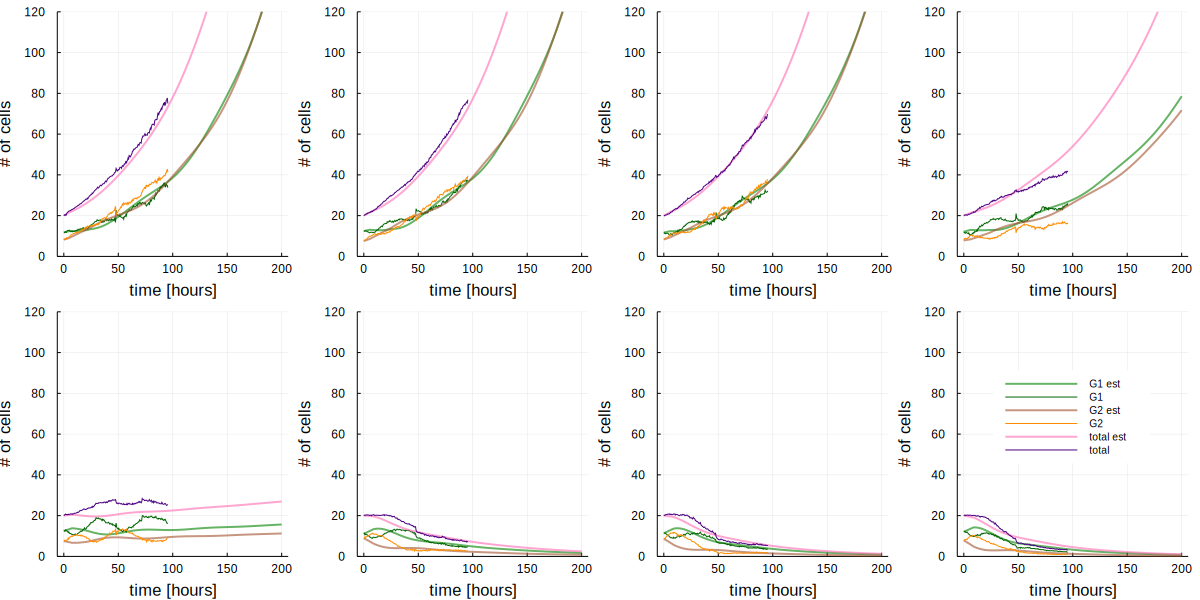

In [4]:
plot_all(pars, popl, g2l, g1l, g2_0l, g1_0l)

### Plot Hill curve for all of the DDE model parameters

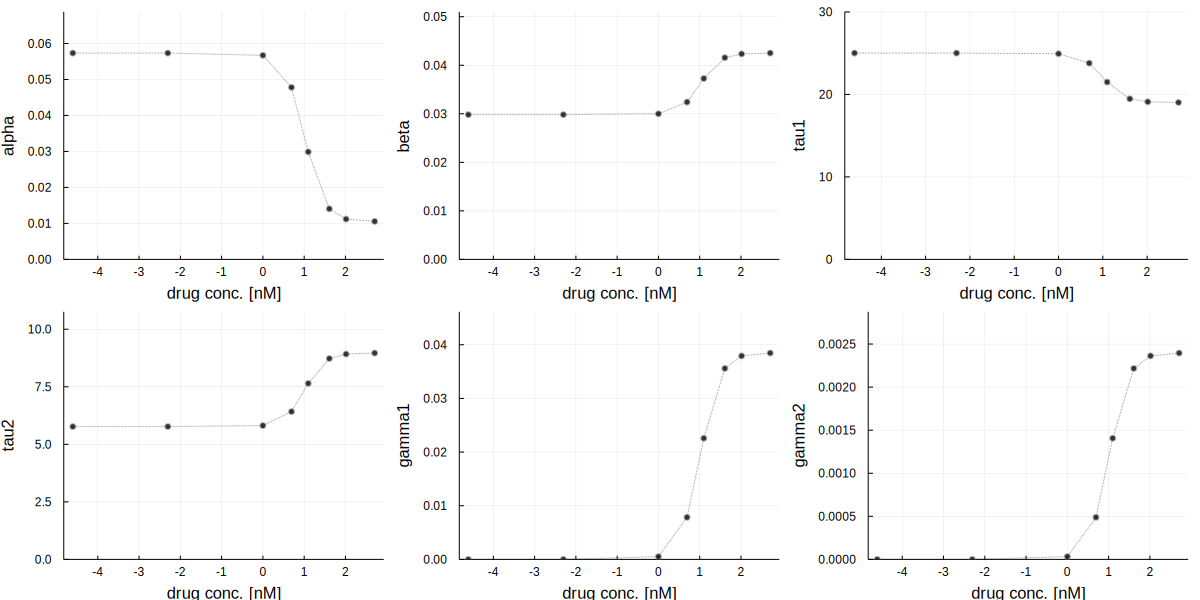

In [13]:
plot_parameters(conc_l, pars)